In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import talib
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
import xgboost as xgb
import warnings
from sklearn.exceptions import DataConversionWarning
# label encoding
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
df = pd.read_csv(f"all_stocks_5yr.csv")
label_encoder = LabelEncoder()
new_names = label_encoder.fit_transform(df['Name']).astype(int)
df['Name'] = new_names
df.Date = pd.to_datetime(df.date)
df

C:\Users\luisf\AppData\Local\Temp\ipykernel_10868\2374843205.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Date = pd.to_datetime(df.date)


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,1
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,1
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,1
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,1
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,1
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,504
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,504
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,504
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,504


In [3]:
def get_talib_features(df, tagets = [-5]):
    op = df['open']
    hi = df['high']
    lo = df['low']
    cl = df['close']
    vo = df['volume']

    df['lag-1'] = df['close'].shift(-1)
    for i, target in enumerate(tagets):
        df[f'target{i}'] = (df['close'].shift(target-1)  - df['lag-1']) / df['lag-1']

    # remove lag-1
    df.drop(columns=['lag-1'], inplace=True)

    df.dropna(inplace=True)
    
    # Overlap Studies
    df['BBANDS_upper'], df['BBANDS_middle'], df['BBANDS_lower'] = talib.BBANDS(cl, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['DEMA'] = talib.DEMA(cl, timeperiod=30)
    df['EMA'] = talib.EMA(cl, timeperiod=30)
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(cl)
    df['KAMA'] = talib.KAMA(cl, timeperiod=30)
    df['MA'] = talib.MA(cl, timeperiod=30, matype=0)
    df['MIDPOINT'] = talib.MIDPOINT(cl, timeperiod=30)
    df['SAR'] = talib.SAR(hi, lo, acceleration=0, maximum=0)
    df['SAREXT'] = talib.SAREXT(hi, lo, startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
    df['SMA'] = talib.SMA(cl, timeperiod=30)
    df['T3'] = talib.T3(df['close'], timeperiod=30, vfactor=0)
    df['TEMA'] = talib.TEMA(df['close'], timeperiod=30)
    df['TRIMA'] = talib.TRIMA(df['close'], timeperiod=30)
    df['WMA'] = talib.WMA(df['close'], timeperiod=30)
    
    # Momentum Indicators
    df['ADX'] = talib.ADX(hi, lo, cl, timeperiod=30)
    df['ADXR'] = talib.ADXR(hi, lo, cl, timeperiod=30)
    df['APO'] = talib.APO(cl, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_down'], df['AROON_up'] = talib.AROON(hi, lo, timeperiod=30)
    df['AROONOSC'] = talib.AROONOSC(hi, lo, timeperiod=30)
    df['BOP'] = talib.BOP(op, hi, lo, cl)
    df['CCI'] = talib.CCI(hi, lo, cl, timeperiod=30)
    df['DX'] = talib.DX(hi, lo, cl, timeperiod=30)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(cl, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MFI'] = talib.MFI(hi, lo, cl, vo, timeperiod=30)
    df['MINUS_DI'] = talib.MINUS_DI(hi, lo, cl, timeperiod=30)
    df['MINUS_DM'] = talib.MINUS_DM(hi, lo, timeperiod=30)
    df['MOM'] = talib.MOM(cl, timeperiod=30)
    df['PLUS_DI'] = talib.PLUS_DI(hi, lo, cl, timeperiod=30)
    df['PLUS_DM'] = talib.PLUS_DM(hi, lo, timeperiod=30)
    df['RSI'] = talib.RSI(cl, timeperiod=30)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(hi, lo, cl, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(hi, lo, cl, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(cl, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(cl, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(hi, lo, cl, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(hi, lo, cl, timeperiod=30)
    
    # Volume Indicators
    df['AD'] = talib.AD(hi, lo, cl, vo)
    df['ADOSC'] = talib.ADOSC(hi, lo, cl, vo, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(cl, vo)
    
    # Volatility Indicators
    df['ATR'] = talib.ATR(hi, lo, cl, timeperiod=30)
    df['NATR'] = talib.NATR(hi, lo, cl, timeperiod=30)
    df['TRANGE'] = talib.TRANGE(hi, lo, cl)
    
    # Cycle Indicators
    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(cl)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(cl)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(cl)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(cl)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(cl)
    
    # Statistic Functions
    df['BETA'] = talib.BETA(hi, lo, timeperiod=5)
    df['CORREL'] = talib.CORREL(hi, lo, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(cl, timeperiod=30) - cl
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(cl, timeperiod=30)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(cl, timeperiod=30) - cl
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(cl, timeperiod=30)
    df['STDDEV'] = talib.STDDEV(cl, timeperiod=30, nbdev=1)   
    
    return df

In [4]:
pricesdf = df[['date', 'open', 'high', 'low', 'close', 'volume', 'Name']]
pricesdf = pricesdf.dropna().reset_index(drop=True)

In [5]:
features = pricesdf.groupby('Name').apply(get_talib_features)
features.dropna(axis=0, inplace=True)
features

date   open   high     low  close   volume  Name   target0  \
Name                                                                            
0    71785   2013-10-17  51.25  52.70  51.130  52.65  3548418     0 -0.021136   
     71786   2013-10-18  52.93  53.24  52.630  52.99  2880870     0 -0.009617   
     71787   2013-10-21  53.04  53.14  51.900  51.99  2556379     0  0.013328   
     71788   2013-10-22  52.10  52.20  50.840  51.02  4280543     0  0.009872   
     71789   2013-10-23  50.76  50.88  50.300  50.65  2348591     0 -0.007042   
...                 ...    ...    ...     ...    ...      ...   ...       ...   
504  619018  2018-01-24  78.16  78.51  77.600  78.33  2585326   504 -0.018044   
     619019  2018-01-25  78.47  79.38  78.345  79.25  2327262   504 -0.041329   
     619020  2018-01-26  79.49  80.13  79.380  80.09  2532808   504 -0.067568   
     619021  2018-01-29  79.81  79.95  79.110  79.18  2662383   504 -0.064837   
     619022  2018-01-30  78.44  78.69  77.910  78.35  3808707   504 -0.037404   

             BBANDS_upper  BBANDS_middle  ...  HT_SINE_sine  HT_SINE_leadsine  \
Name                                      ...                                   
0    71785      52.747532         51.582  ...     -0.996274         -0.765460   
     71786      53.487370         51.888  ...     -0.992314         -0.614171   
     71787      53.523893         52.014  ...     -0.887617         -0.301960   
     71788      53.469692         52.042  ...     -0.131241          0.608189   
     71789      53.668336         51.860  ...      0.835441          0.979358   
...                   ...            ...  ...           ...               ...   
504  619018     78.705604         77.270  ...      0.111461         -0.623886   
     619019     79.622100         77.854  ...      0.112587         -0.623000   
     619020     80.543290         78.548  ...      0.172716         -0.574352   
     619021     80.598504         78.888  ...      0.217255         -0.536595   
     619022     80.350389         79.040  ...      0.235209         -0.520951   

             HT_TRENDMODE      BETA    CORREL  LINEARREG  LINEARREG_ANGLE  \
Name                                                                        
0    71785              1  0.339815  0.958690  -0.387720         6.732171   
     71786              1  0.576773  0.953425  -0.626258         6.405098   
     71787              1  0.849013  0.947961   0.347118         5.774950   
     71788              0  1.064091  0.939980   1.181355         4.920657   
     71789              0  0.826001  0.931260   1.380043         4.026624   
...                   ...       ...       ...        ...              ...   
504  619018             1 -0.113137  0.990188  -1.560946        11.649149   
     619019             1  0.062575  0.992144  -1.920839        12.821950   
     619020             1  0.088691  0.993047  -2.111742        14.267546   
     619021             1  0.822188  0.993772  -0.708817        15.251333   
     619022             1  1.040707  0.993858   0.423591        15.555215   

             LINEARREG_INTERCEPT  LINEARREG_SLOPE    STDDEV  
Name                                                         
0    71785             -3.810946         0.118042  1.440146  
     71786             -3.881742         0.112258  1.383256  
     71787             -2.585785         0.101135  1.299597  
     71788             -1.315355         0.086093  1.226133  
     71789             -0.661376         0.070394  1.170849  
...                          ...              ...       ...  
504  619018            -7.539720         0.206165  2.023536  
     619019            -8.521161         0.227597  2.212553  
     619020            -9.486258         0.254294  2.437907  
     619021            -8.615849         0.272656  2.562621  
     619022            -7.648925         0.278363  2.599007  

[528402 rows x 72 columns]

In [6]:
train_features_cols = [i for i in features.columns if i not in ['date', 'target0',  'open', 'high', 'low', 'close', 'volume', 'Name']]
# 'open', 'high', 'low', 'close', 'volume', 
train_target_cols = ['target0']
train_features_cols, features.shape

(['BBANDS_upper',
  'BBANDS_middle',
  'BBANDS_lower',
  'DEMA',
  'EMA',
  'HT_TRENDLINE',
  'KAMA',
  'MA',
  'MIDPOINT',
  'SAR',
  'SAREXT',
  'SMA',
  'T3',
  'TEMA',
  'TRIMA',
  'WMA',
  'ADX',
  'ADXR',
  'APO',
  'AROON_down',
  'AROON_up',
  'AROONOSC',
  'BOP',
  'CCI',
  'DX',
  'MACD_macd',
  'MACD_macdsignal',
  'MACD_macdhist',
  'MFI',
  'MINUS_DI',
  'MINUS_DM',
  'MOM',
  'PLUS_DI',
  'PLUS_DM',
  'RSI',
  'STOCH_slowk',
  'STOCH_slowd',
  'STOCHF_fastk',
  'STOCHF_fastd',
  'STOCHRSI_fastk',
  'STOCHRSI_fastd',
  'TRIX',
  'ULTOSC',
  'WILLR',
  'AD',
  'ADOSC',
  'OBV',
  'ATR',
  'NATR',
  'TRANGE',
  'HT_DCPERIOD',
  'HT_DCPHASE',
  'HT_PHASOR_inphase',
  'HT_PHASOR_quadrature',
  'HT_SINE_sine',
  'HT_SINE_leadsine',
  'HT_TRENDMODE',
  'BETA',
  'CORREL',
  'LINEARREG',
  'LINEARREG_ANGLE',
  'LINEARREG_INTERCEPT',
  'LINEARREG_SLOPE',
  'STDDEV'],
 (528402, 72))

In [7]:
features.set_index('Name', inplace=True)

In [8]:
traindf = features.loc[(features['date'] < '2016-01-01')]
testdf = features.loc[features['date'] > '2016-01-01']
traindf.shape, testdf.shape

((268942, 71), (259460, 71))

In [9]:
Xtrain = traindf[train_features_cols]
Ytrain = traindf[train_target_cols]

Xtest = testdf[train_features_cols]
Ytest = testdf[train_target_cols]

In [10]:
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((268942, 64), (268942, 1), (259460, 64), (259460, 1))

In [11]:
from sklearn.metrics import mean_absolute_error, r2_score

name = 1
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    learning_rate=0.1,
    max_depth=16, 
    n_estimators=128, 
    gpu_id=0, 
    colsample_bytree=0.1, 
)

print(Xtrain.loc[name].shape, Ytrain.loc[name].shape)
#model.fit(Xtrain.loc[name], Ytrain.loc[name])
model.fit(Xtrain.loc[name], Ytrain.loc[name]) #, verbose = True, eval_metric = 'mae', eval_set = [(Xtest.loc[name], Ytest.loc[name])])

preds = model.predict(Xtest.loc[name])
print(name, ' - MAE:', mean_absolute_error(Ytest.loc[name], preds), 'R2:', r2_score(Ytest.loc[name], preds), 'STD: ', np.std(preds))
#print(preds)

(556, 64) (556, 1)
1  - MAE: 0.04943120386827242 R2: -0.8115609828701102 STD:  0.04450992


In [12]:
# get unique names
unique_names = traindf.index.unique()

models = dict()
for name in tqdm(unique_names):
    model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        learning_rate=0.1,
        max_depth=32, 
        n_estimators=128,
        min_child_weight=4, 
        gpu_id=0, 
        colsample_bytree=0.5, 
        reg_alpha = 0.8,
        subsample = 0.7,
        alpha = 1
    )

    model.fit(Xtrain.loc[name], Ytrain.loc[name]) #, verbose = True, eval_metric = 'mae', eval_set = [(Xtrain.loc[name], Ytrain.loc[name])])

    preds = model.predict(Xtest.loc[name])
    print(name, ' - MAE:', mean_absolute_error(Ytest.loc[name], preds), 'R2:', r2_score(Ytest.loc[name], preds), 'STD: ', np.std(preds))
    #print(preds)
    models[name] = model


  0%|          | 0/489 [00:00<?, ?it/s]

0  - MAE: 0.025172253964234073 R2: -0.46650138295962873 STD:  0.015139889
1  - MAE: 0.04962969984392066 R2: -0.5442358300320855 STD:  0.033982962
2  - MAE: 0.03856876416808549 R2: -0.23537647314045973 STD:  0.018531816
3  - MAE: 0.026418560374901846 R2: -0.45396503218806794 STD:  0.0149785895
4  - MAE: 0.02834825112161652 R2: -0.2559242254119569 STD:  0.019384993
5  - MAE: 0.030034931628644117 R2: -0.08716735317266444 STD:  0.014760052
6  - MAE: 0.0267609397638118 R2: -0.5199504626331011 STD:  0.016631624
7  - MAE: 0.018638104162185656 R2: -0.18842157032098328 STD:  0.009506245
8  - MAE: 0.028489110052783036 R2: -0.5111898026451658 STD:  0.021987079
9  - MAE: 0.02672547381572122 R2: -0.35556551271484493 STD:  0.014589001
10  - MAE: 0.029627828977390063 R2: -0.3656199497787125 STD:  0.014179871
11  - MAE: 0.01903534985419915 R2: -0.07733034163626873 STD:  0.008181462
12  - MAE: 0.043373953513174766 R2: -0.5441426430694651 STD:  0.017618645
13  - MAE: 0.03592080185495074 R2: -0.170388422

In [13]:
preddf = pd.DataFrame()
unique_testdf = testdf.index.unique()
for i in tqdm(unique_testdf):
    if i in models.keys():
        group = testdf.loc[i]
        preds = models[i].predict(group[train_features_cols])
        dates = group['date'].values
        predgroupdf = pd.DataFrame(dates, columns=['Date'], index=group.index)
        predgroupdf['pred'] = preds
        predgroupdf['Target'] = group['target0']

        preddf = pd.concat([preddf, predgroupdf])
preddf

  0%|          | 0/501 [00:00<?, ?it/s]

,Date,pred,Target
Name,,,
0,2016-01-04,-0.026058,-0.058200
0,2016-01-05,-0.024352,-0.095016
0,2016-01-06,-0.025001,-0.035641
0,2016-01-07,-0.007595,-0.038352
0,2016-01-08,-0.009564,-0.019504
...,...,...,...
504,2018-01-24,0.011094,-0.018044
504,2018-01-25,0.017240,-0.041329
504,2018-01-26,0.024394,-0.067568


In [14]:
from sklearn.metrics import mean_absolute_error, r2_score

dates = []
avgindex = []
optimalpred_avg10 = []
worstpred_avg10 = []
returns10 = []
optimalpred_avg5 = []
worstpred_avg5 = []
returns5 = []

r2 = []

unique_dates = preddf['Date'].unique()
for date in tqdm(unique_dates):
    group = preddf.loc[preddf['Date'] == date]
    dates.append(date)
    avgindex.append(group['Target'].mean())

    rank = group['pred'].argsort()
    r2.append(r2_score(group['Target'], group['pred']))
    optimalpred_avg10.append(group['Target'].iloc[rank[-50:]].mean())
    worstpred_avg10.append(group['Target'].iloc[rank[:50]].mean())
    returns10.append(group['Target'].iloc[rank[-50:]])
    optimalpred_avg5.append(group['Target'].iloc[rank[-10:]].mean())
    worstpred_avg5.append(group['Target'].iloc[rank[:10]].mean())
    returns5.append(group['Target'].iloc[rank[-10:]])

indexsum = np.cumsum(avgindex)
optimalpred_avg10 = np.cumsum(optimalpred_avg10)
worstpred_avg10 = np.cumsum(worstpred_avg10)
optimalpred_avg5 = np.cumsum(optimalpred_avg5)
worstpred_avg5 = np.cumsum(worstpred_avg5)

  0%|          | 0/523 [00:00<?, ?it/s]

In [15]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=indexsum, name='Index avg.'))
fig.add_trace(go.Scatter(x=dates, y=optimalpred_avg10, name='Top 10%'))
fig.add_trace(go.Scatter(x=dates, y=worstpred_avg10, name='Bottom 10%'))
fig.add_trace(go.Scatter(x=dates, y=optimalpred_avg5, name='Top 5%'))
fig.add_trace(go.Scatter(x=dates, y=worstpred_avg5, name='Bottom 5%'))
fig.update_layout(title='Index avg., top 10%, Bottom 10%')
fig.show()

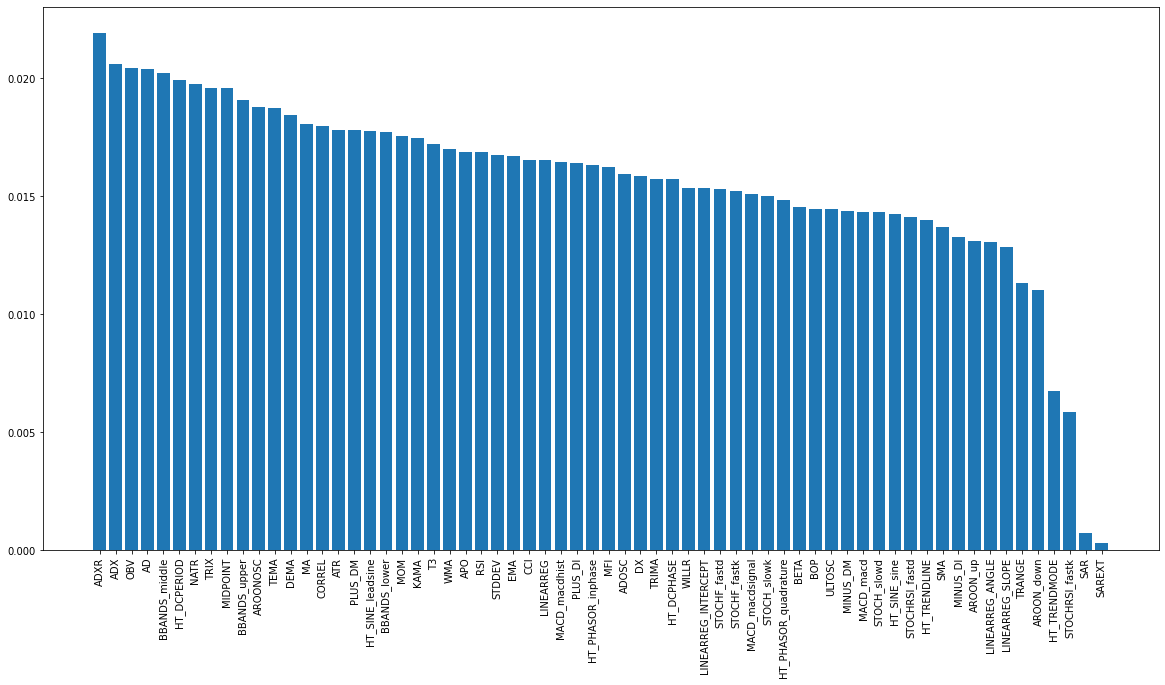

In [16]:
features = train_features_cols
importancedf = pd.DataFrame(columns=features)

for i in models:
    importancedf.loc[i] = models[i].feature_importances_

average_importance = importancedf.mean(axis=0)

order = average_importance.argsort()[::-1]

plt.figure(figsize=(20,10))
plt.bar(range(len(average_importance)), average_importance[order])
ticks = plt.xticks(range(len(average_importance)), importancedf.columns[order], rotation='vertical')

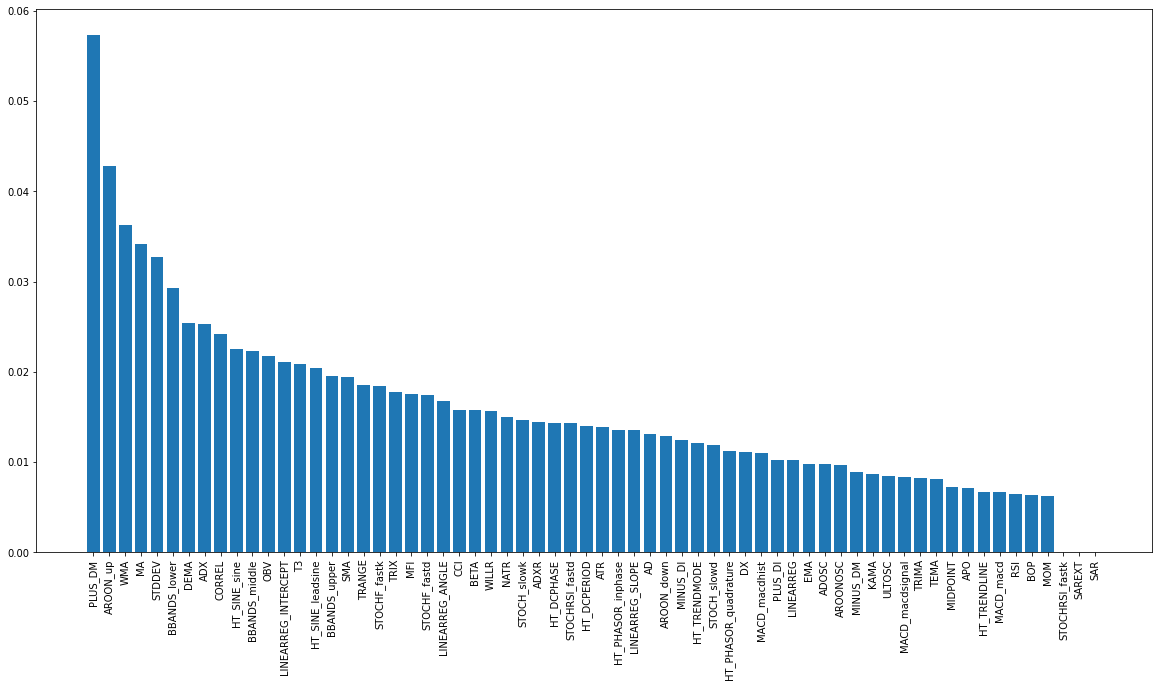

In [17]:
feature_importance = models[2].feature_importances_
features = train_features_cols

features_order = np.argsort(feature_importance)[::-1]

feature_importance = feature_importance[features_order]
features = np.array(features)[features_order]

feature_importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance})

plt.figure(figsize=(20,10))
plt.bar(range(len(features)), feature_importance)
ticks = plt.xticks(range(len(features)), features, rotation='vertical')

In [18]:
fig = px.bar(feature_importance_df.iloc[0:5], x="importance", y="feature", orientation='h', height=800)
fig.show()

In [19]:
npreturns10 = np.concatenate(returns10)
npreturns5 = np.concatenate(returns5)
npreturns10.shape, npreturns5.shape

((26150,), (5230,))

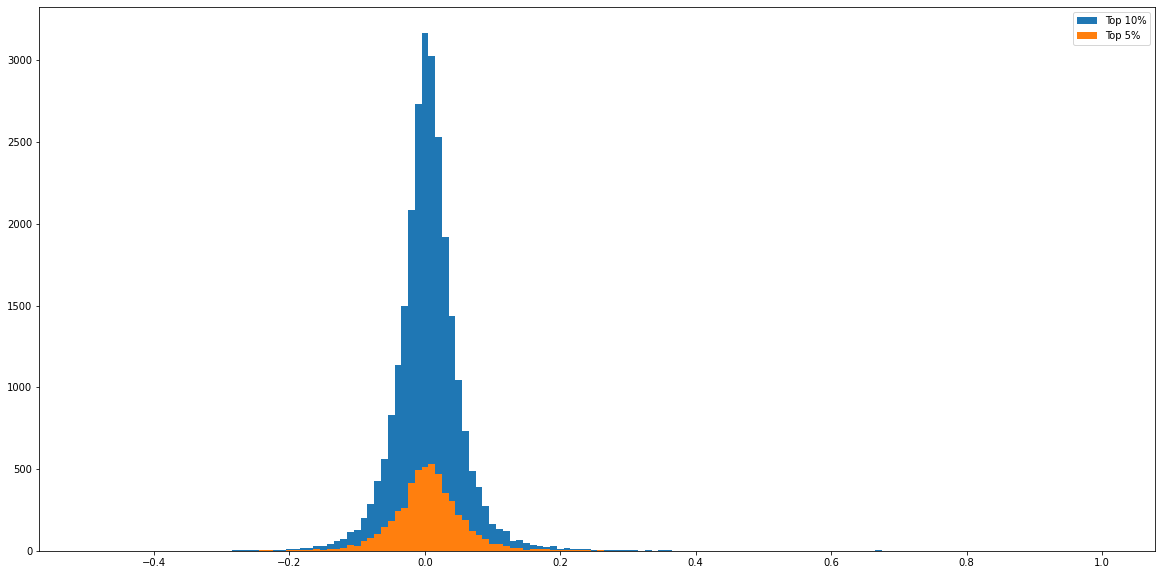

In [20]:
# histogram of returns
plt.figure(figsize=(20,10))
plt.hist(npreturns10, bins=150, label='Top 10%')
plt.hist(npreturns5, bins=150, label='Top 5%')
plt.legend()
plt.show()

In [21]:
npreturns10.sum(), npreturns5.sum()

(124.37084017749065, 30.044376595523666)